In [1]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

from emccd_detect import emccd_detect
meta_path = Path('/home/kianmilani/Projects/emccd_detect/emccd_detect/emccd_detect/util/metadata.yaml')

dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


INFO:numexpr.utils:Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


2024-02-11 21:00:30,933	INFO worker.py:1636 -- Started a local Ray instance.


1.3624486320346218e-17 sr
	Flux for wavelength 7.838e-07 m: 7.662e+08 ph / (s m2)
	Flux for wavelength 8.044e-07 m: 7.115e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 6.650e+08 ph / (s m2)
	Flux for wavelength 8.456e-07 m: 6.195e+08 ph / (s m2)
	Flux for wavelength 8.663e-07 m: 5.809e+08 ph / (s m2)
Total flux: 3.343e+09 ph / (s m2)


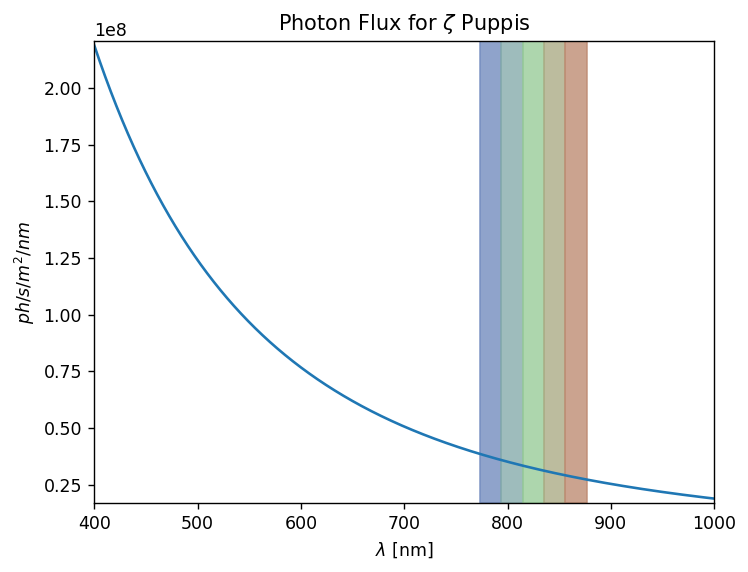

In [2]:
reload(cgi_phasec_poppy.source_flux)
wavelength_c = 825e-9*u.m

nwaves = 5
bandwidth = 10/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph()
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
print(f'Total flux: {total_flux:.3e}')

In [7]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=4, num_gpus=1/8).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    # actors[i].setattr.remote('source_flux', source_fluxes[i])

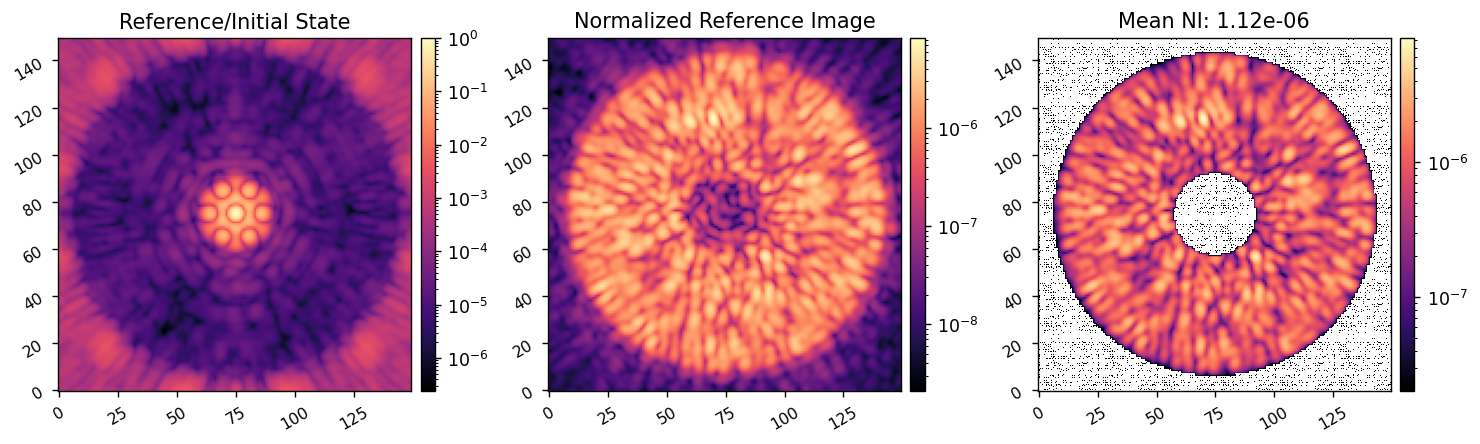

In [3]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True,
                                  dm1_ref=2*dm1_flat, 
                                  # dm2_ref=dm2_flat,
                                #   dm1_shift=np.array([0.00011,0]),
                                #   dm2_shift=np.array([-0.00011,0]),
                                #   dm1_rot = 0.1,
                                #   dm2_rot = -0.1,
                                  )
mode.wavelengths = wavelengths
mode.exp_times_list = None
mode.use_fpm = False
# raw_im = mode.snap_bb(wavelengths)
raw_im = mode.snap()

mode.Imax_ref = raw_im.get().max()
# ref_unocc_im = mode.snap_bb(wavelengths)
ref_unocc_im = mode.snap()

mode.use_fpm = True
# ref_im = mode.snap_bb(wavelengths)
ref_im = mode.snap()

control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None)
mean_ni = xp.mean(ref_im[control_mask])
imshow3(ref_unocc_im, ref_im, ref_im*control_mask, 
        f'Reference/Initial State', 
        'Normalized Reference Image',
        f'Mean NI: {mean_ni:.2e}',
        lognorm=True,)



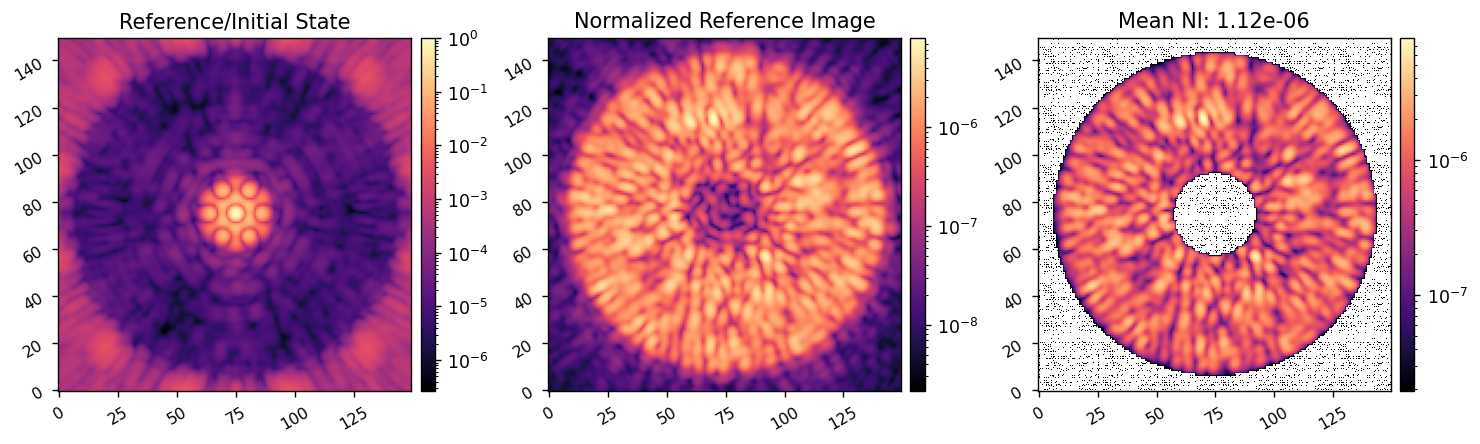

In [6]:
mode = cgi_phasec_poppy.cgi.CGI(cgi_mode='spc-wide', npsf=150,
                                  use_pupil_defocus=True, 
                                  use_opds=True,
                                  dm1_ref=2*dm1_flat, 
                                  # dm2_ref=dm2_flat,
                                #   dm1_shift=np.array([0.00011,0]),
                                #   dm2_shift=np.array([-0.00011,0]),
                                #   dm1_rot = 0.1,
                                #   dm2_rot = -0.1,
                                  )
mode.wavelengths = wavelengths
mode.exp_times_list = None
mode.use_fpm = False
# raw_im = mode.snap_bb(wavelengths)
raw_im5 = mode.snap()

mode.Imax_ref = raw_im5.get().max()
# ref_unocc_im = mode.snap_bb(wavelengths)
ref_unocc_im5 = mode.snap()

mode.use_fpm = True
# ref_im = mode.snap_bb(wavelengths)
ref_im5 = mode.snap()

control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None)
mean_ni = xp.mean(ref_im5[control_mask])
imshow3(ref_unocc_im5, ref_im5, ref_im5*control_mask, 
        f'Reference/Initial State', 
        'Normalized Reference Image',
        f'Mean NI: {mean_ni:.2e}',
        lognorm=True,)


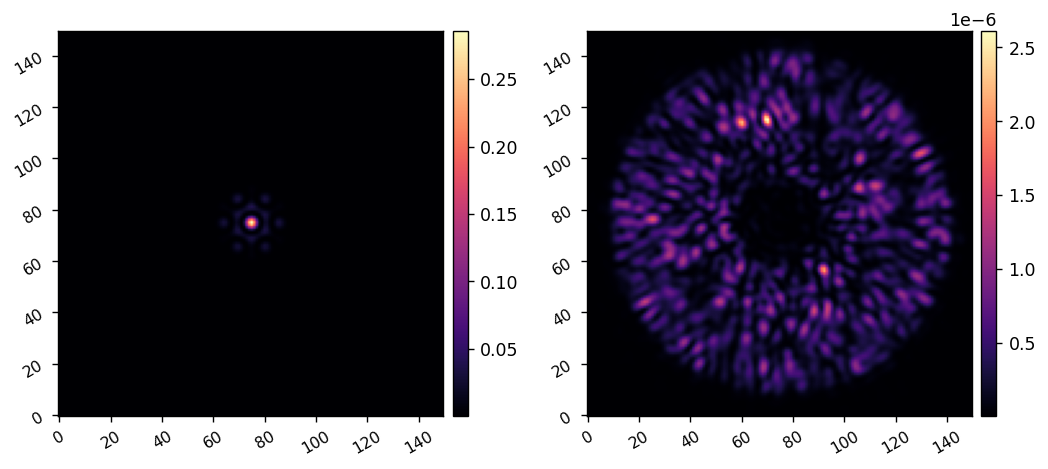

In [6]:
imshow2(ref_unocc_im-ref_unocc_im5, ref_im-ref_im5)

In [12]:
mode


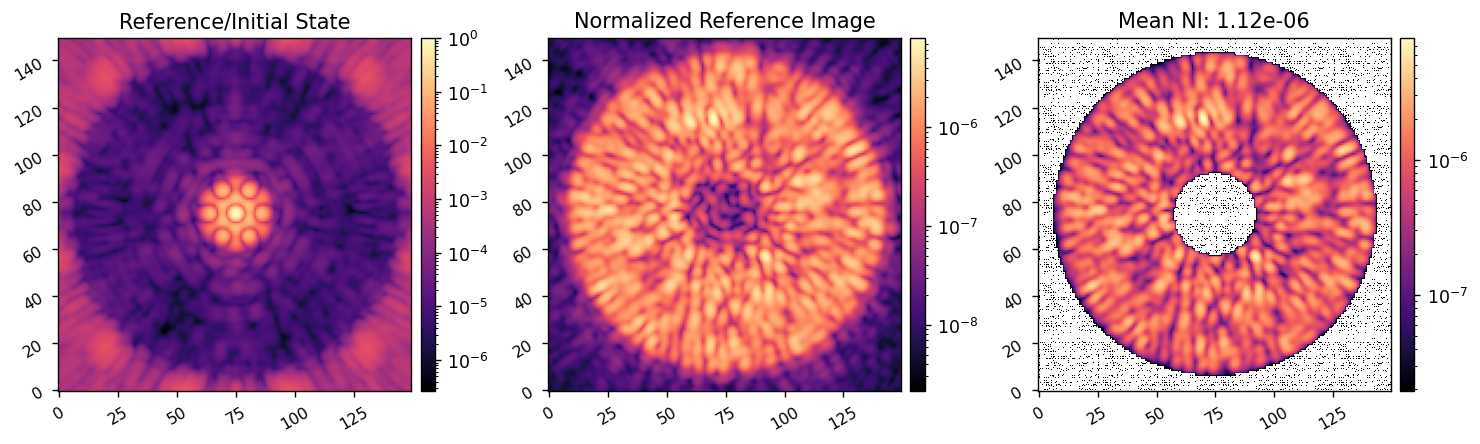

In [8]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors, dm1_ref=2*dm1_flat,)
mode.exp_times_list = None

mode.set_actor_attr('use_fpm',False)
raw_im = mode.snap()

mode.normalize = True
mode.Imax_ref = xp.max(raw_im)

ref_unocc_im = mode.snap()

mode.set_actor_attr('use_fpm',True)
ref_im = mode.snap()

control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None)
mean_ni = xp.mean(ref_im[control_mask])
imshow3(ref_unocc_im, ref_im, ref_im*control_mask, 
        f'Reference/Initial State', 
        'Normalized Reference Image',
        f'Mean NI: {mean_ni:.2e}',
        lognorm=True,)


# Create calibration and probe modes

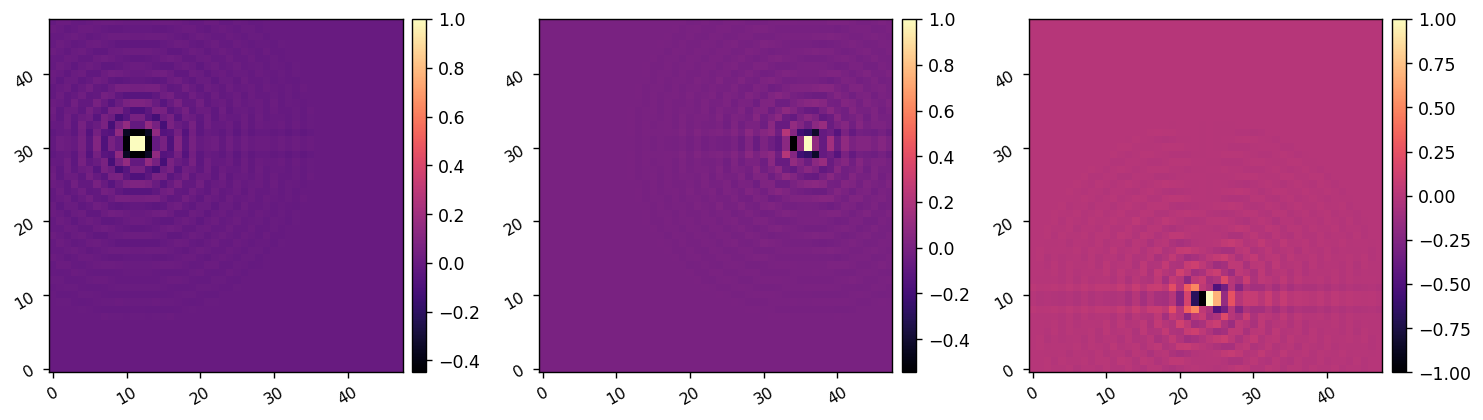

(4096, 4608)


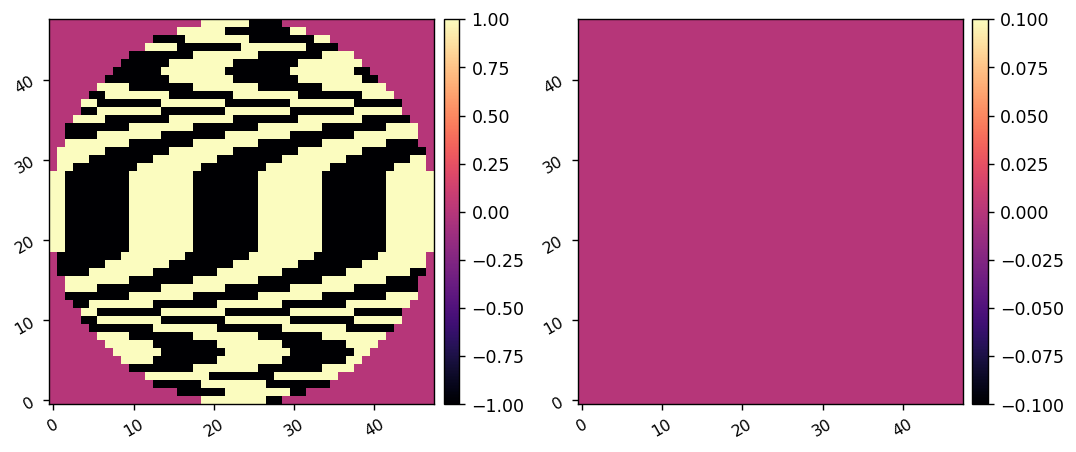

In [7]:
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.2,
                                          shift=[(-12,7), (12,7),(0,-14), (0,0)], nprobes=3,
                                           use_weighting=True)
imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+mode.Nacts,mode.Nact**2:].reshape(mode.Nact,mode.Nact))



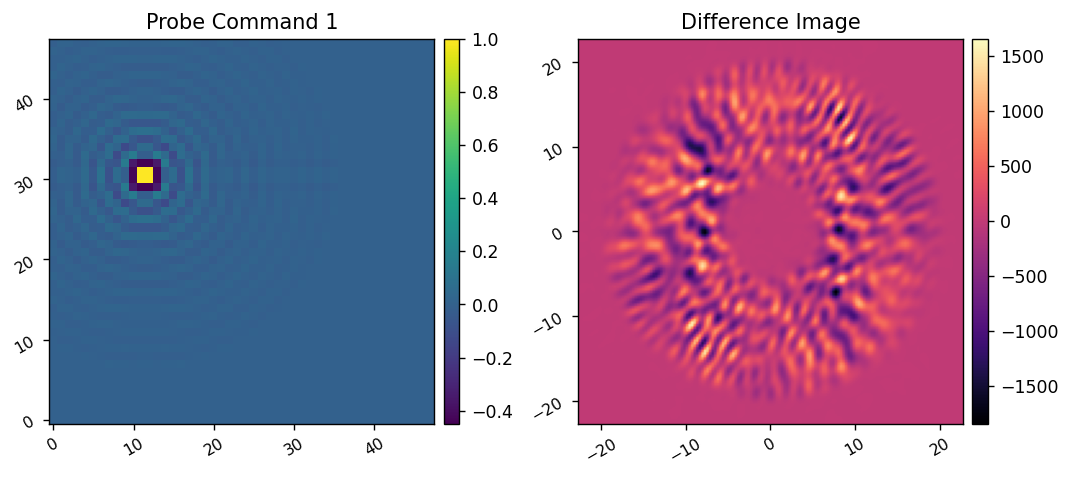

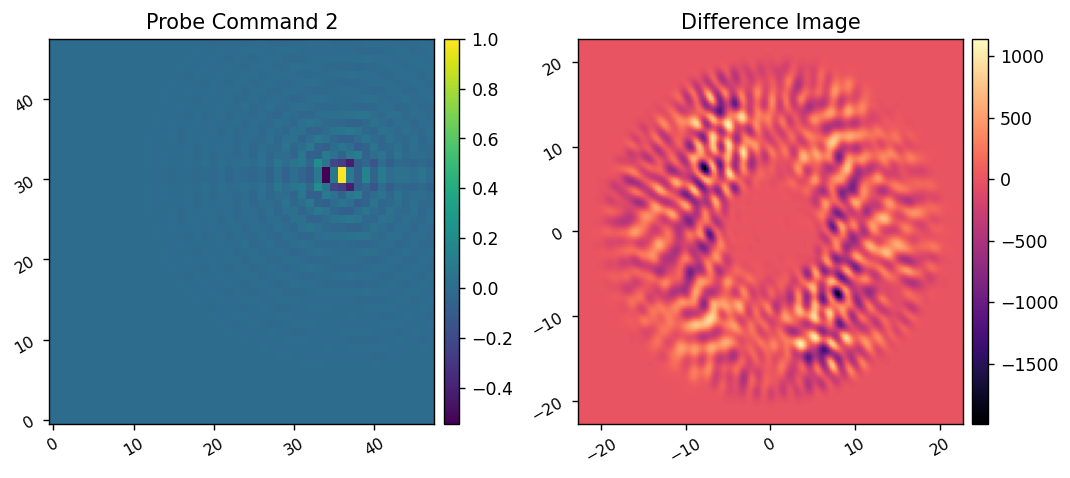

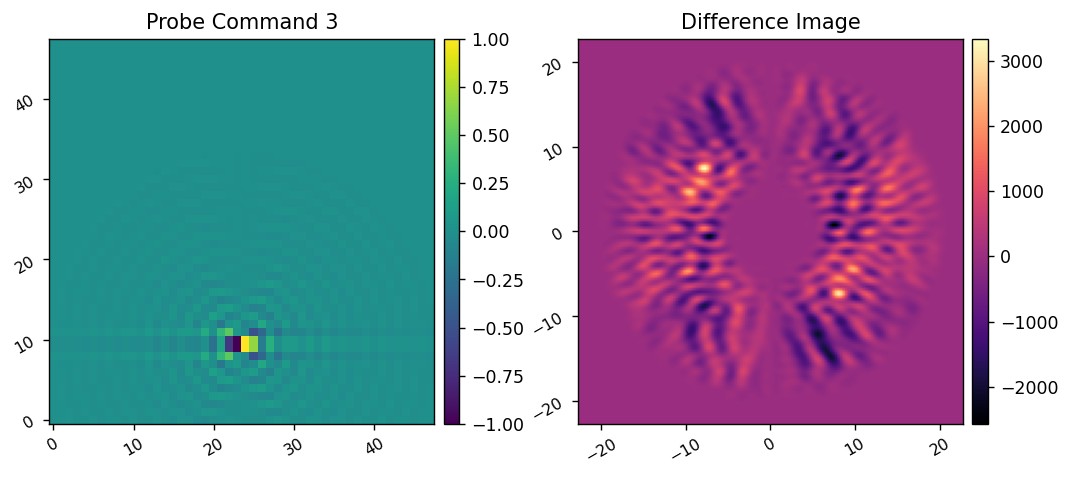

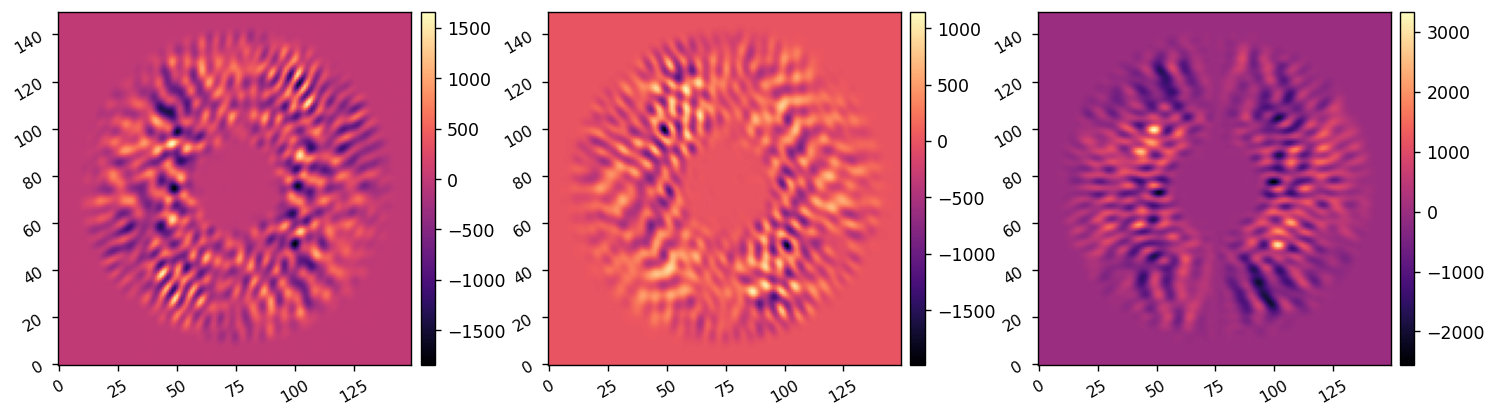

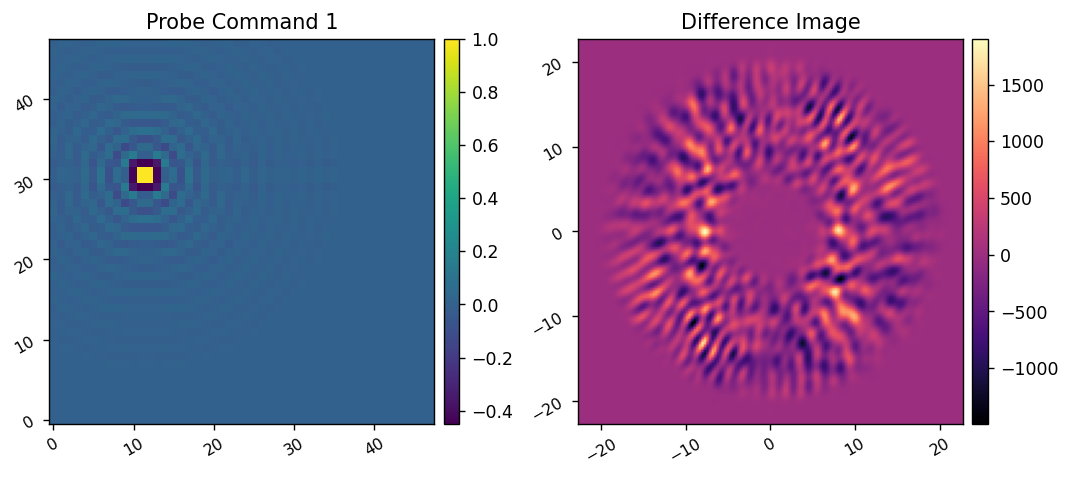

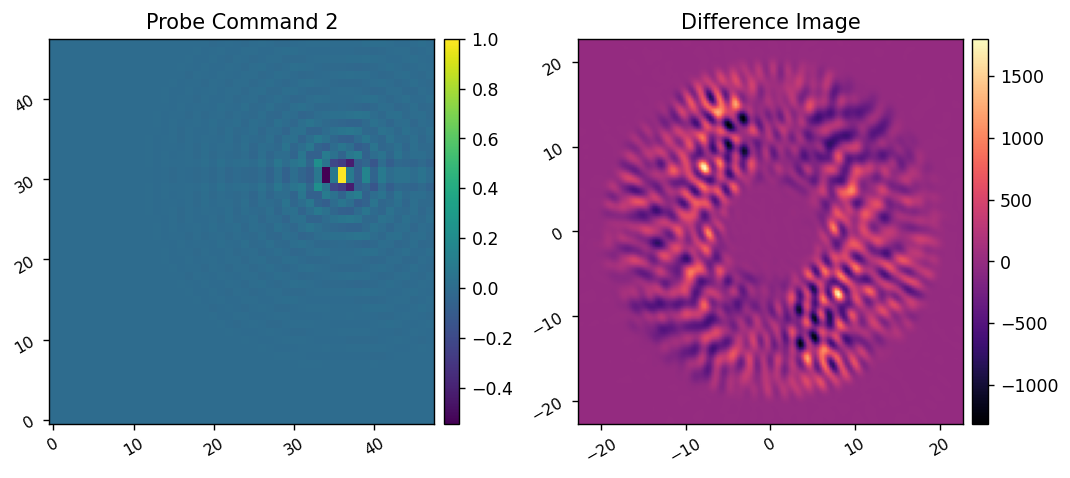

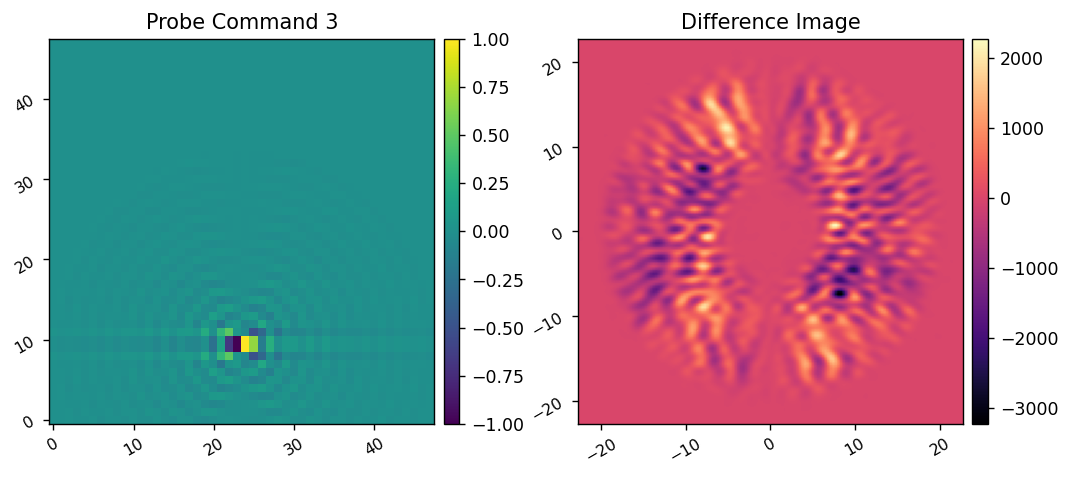

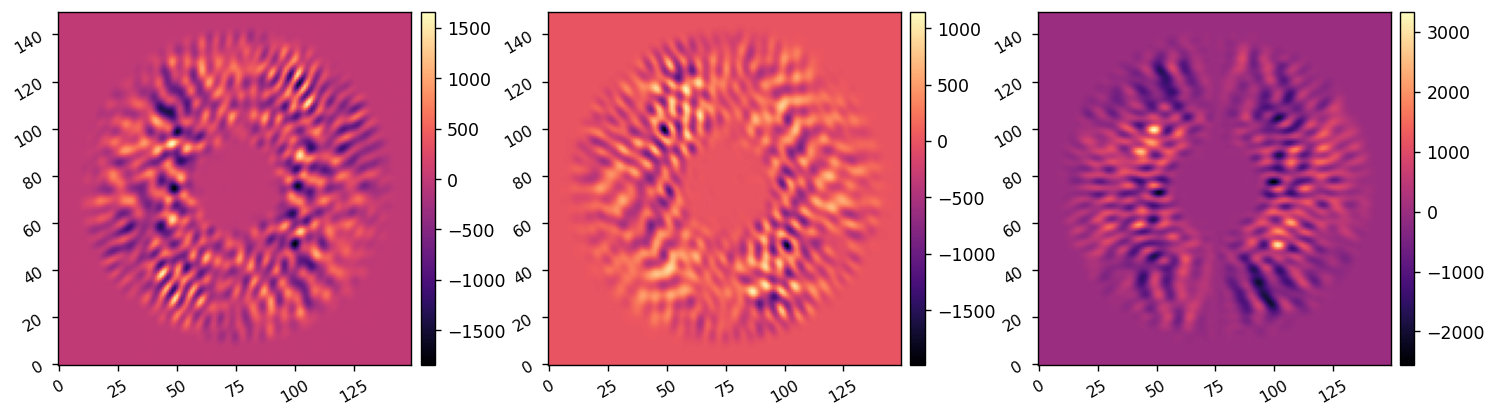

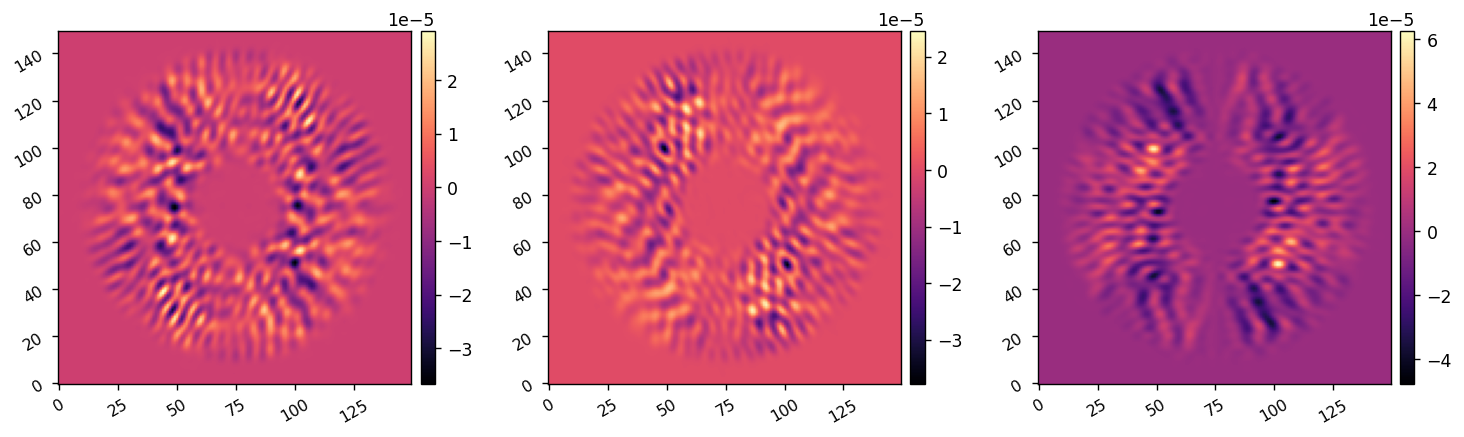

In [10]:
reload(iefc_2dm)
mode.normalize = True

i = 190

calib_amp = 5e-9
probe_amp = 20e-9

dm_mode = calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact)

mode.add_dm1(calib_amp* dm_mode)
differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
diff_ims1 = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
mode.add_dm1(-calib_amp*dm_mode)
imshow3(diff_ims1[0], diff_ims1[1], diff_ims1[2])

mode.add_dm1(-calib_amp* dm_mode)
differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
diff_ims2 = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
mode.add_dm1(+calib_amp*dm_mode)
imshow3(diff_ims1[0], diff_ims1[1], diff_ims1[2])

responses = 2*calib_amp*(diff_ims1-diff_ims2)
imshow3(responses[0], responses[1], responses[2])




In [9]:
17.7*4096/3600

20.138666666666666

Calibrating iEFC...
	Calibrated mode 1/2 in 17.678s
	Calibrated mode 2/2 in 35.160s

Calibration complete.


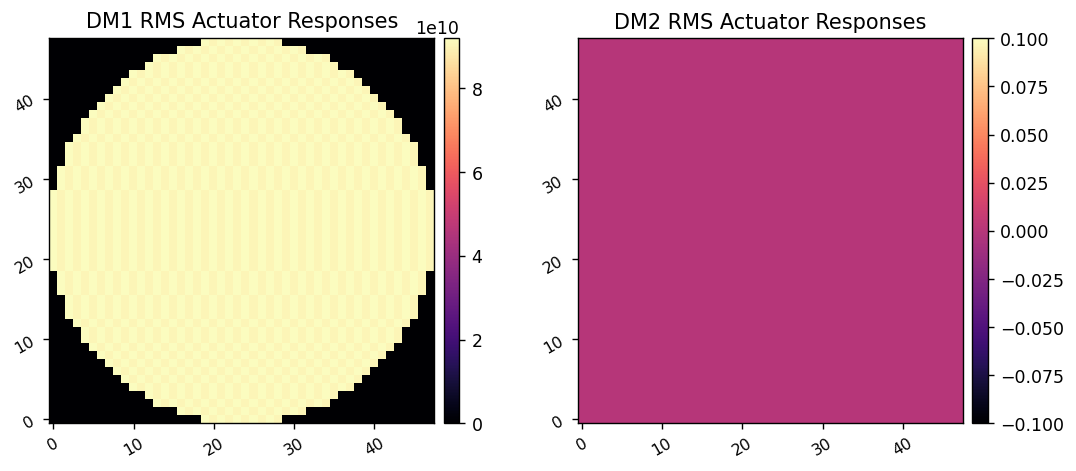

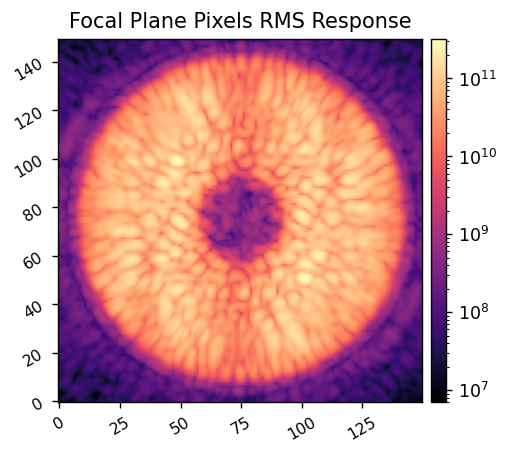

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_matrix_20240211.fits


In [8]:
reload(iefc_2dm)

mode.reset_dms()
mode.exp_times_list = None

calib_amp = 5e-9
probe_amp = 20e-9

response_matrix, response_cube, calib_amps = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                     calib_amp, calib_modes[190:192], 
                                                     return_all=True, 
#                                                     plot_responses=False,
                                                   )

utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
# utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [15]:
date = 20230912
date = 20230913
date = 20230918
date = 20230920
# date = 20230921
date = 20231017
date = 20231220
date = 20231227
date = 20240103
response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_band4b_emccd_response_matrix_{date}.fits'))
response_info = fits.getheader(response_dir/f'spc_wide_band4b_emccd_response_matrix_{date}.fits')
display(response_info)
# response_cube = xp.array(fits.getdata(data_dir/response_dir/f'spc_wide_825_poke_modes_response_cube_{date}.fits'))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096                                                  
NAXIS2  =                40572                                                  
EM_GAIN =                  500                                                  

In [21]:
xp.mean(response_matrix.dot(xp.array(calib_modes)), axis=0).shape

(4608,)

9504367462282.117


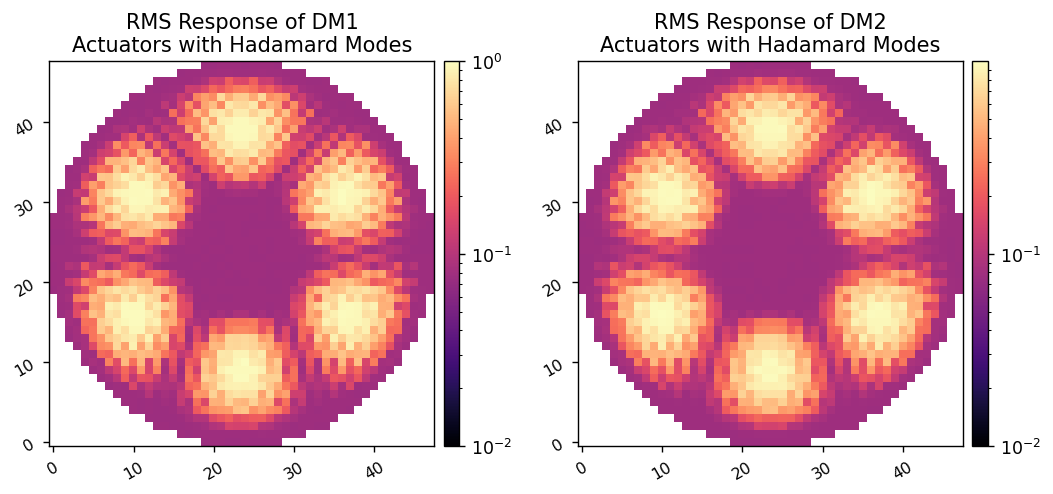

In [16]:
response_matrix.shape

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Hadamard Modes', 'RMS Response of DM2\nActuators with Hadamard Modes',
        lognorm=True, vmin1=0.01, vmin2=0.01,
        )


# Run IEFC

In [43]:
mode.reset_dms()
images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])
regs = xp.array([])

mode.reset_dms()

Running iEFC...
	Closed-loop iteration 28 / 30
False
False


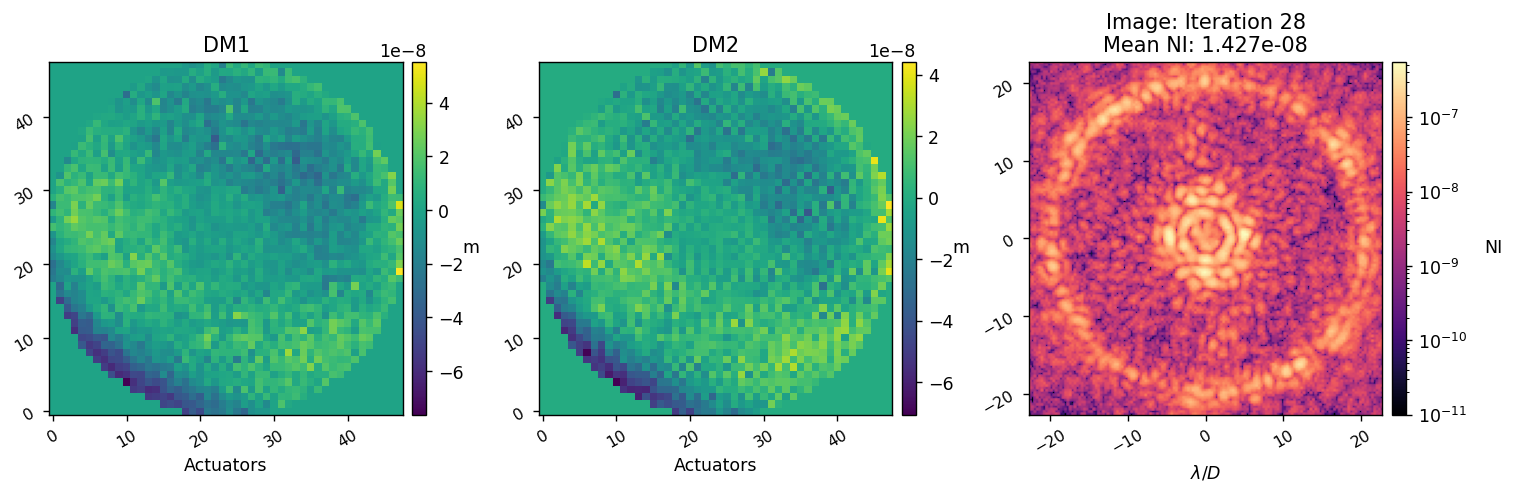

	Closed-loop iteration 29 / 30
False
False


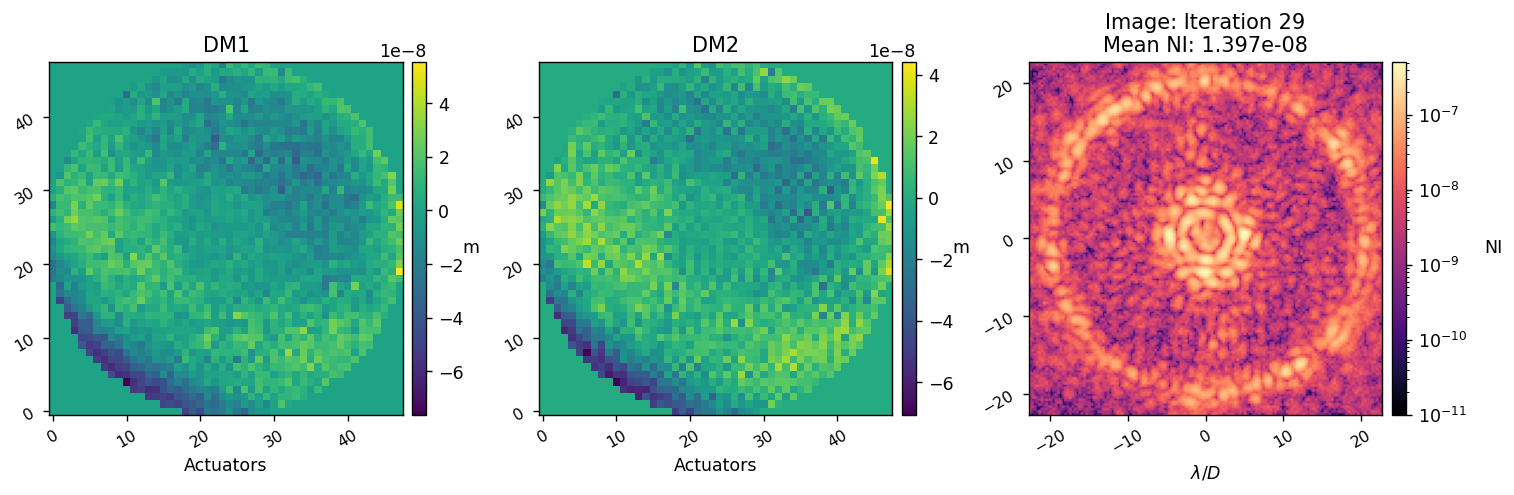

	Closed-loop iteration 30 / 30
False
False


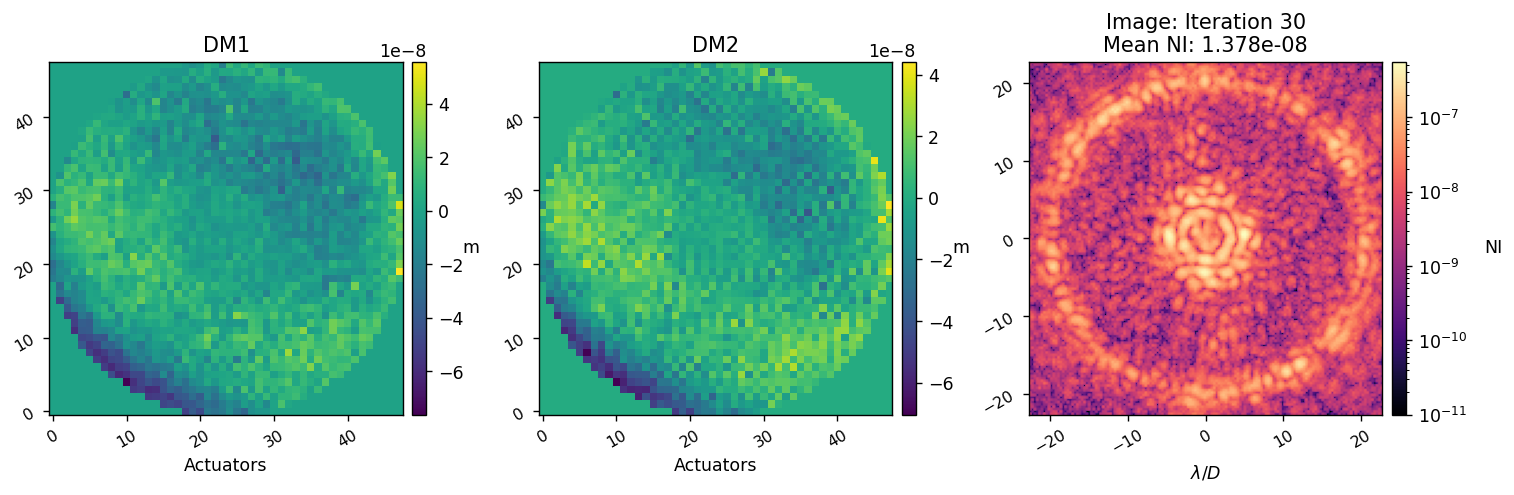

Closed loop for given control matrix completed in 23.706s.


In [95]:
reload(iefc_2dm)
reload(utils)

mode.normalize = True

images, dm1_commands, dm2_commands, regs = iefc_2dm.run(mode, 
                                                        response_matrix,
                                                        reg_fun, reg_conds, 
                                                        probe_modes, 
                                                        probe_amp, 
                                                        calib_modes,
                                                        control_mask, 
                                                        num_iterations=3, 
                                                        loop_gain=0.5, 
                                                        leakage=0,
                                                        probe_exp_time=probe_exp_times,
                                                        probe_nframes=probe_Nframes,
                                                        probe_em_gain=probe_em_gain,
                                                        metric_exp_time=metric_exp_times,
                                                        metric_nframes=metric_Nframes,
                                                        metric_em_gain=metric_em_gain,
                                                        plot_all=True,
                                                        plot_radial_contrast=False,
                                                        old_images=images,
                                                        old_dm1_commands=dm1_commands,
                                                        old_dm2_commands=dm2_commands,
                                                        old_regs=regs,
                                              )

Running iEFC...
	Closed-loop iteration 28 / 30


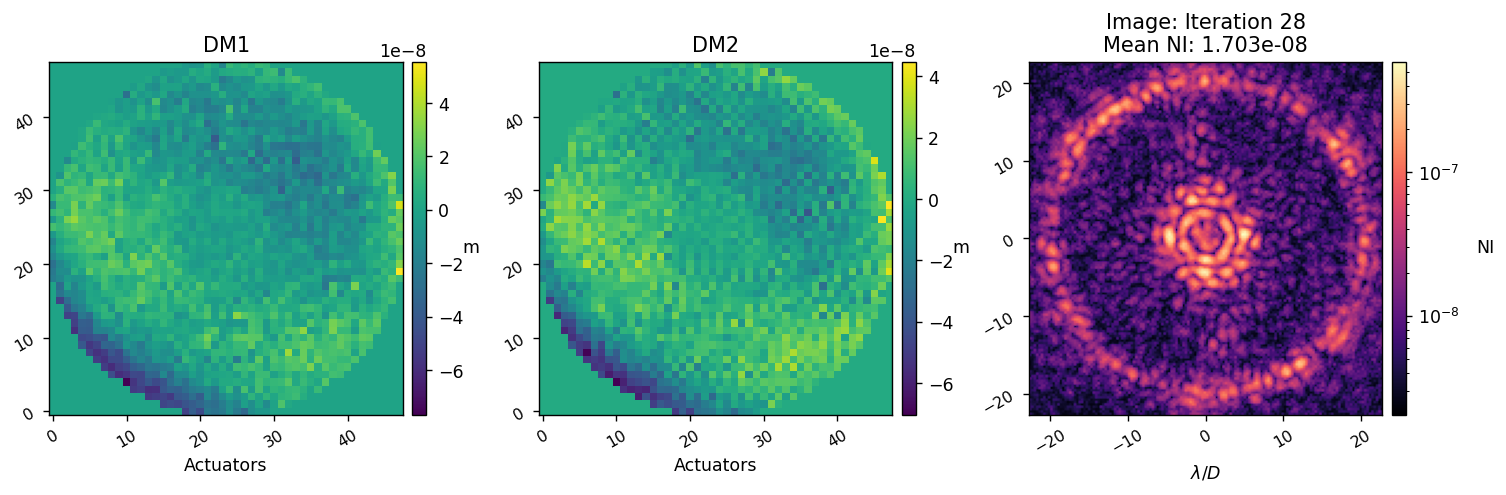

	Closed-loop iteration 29 / 30


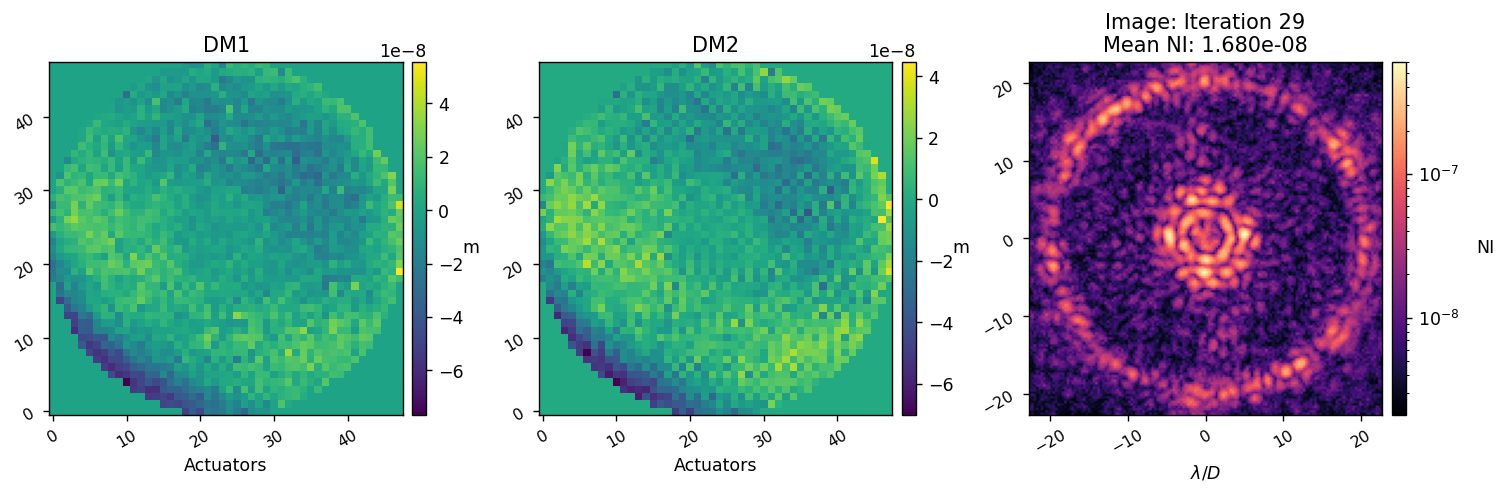

	Closed-loop iteration 30 / 30


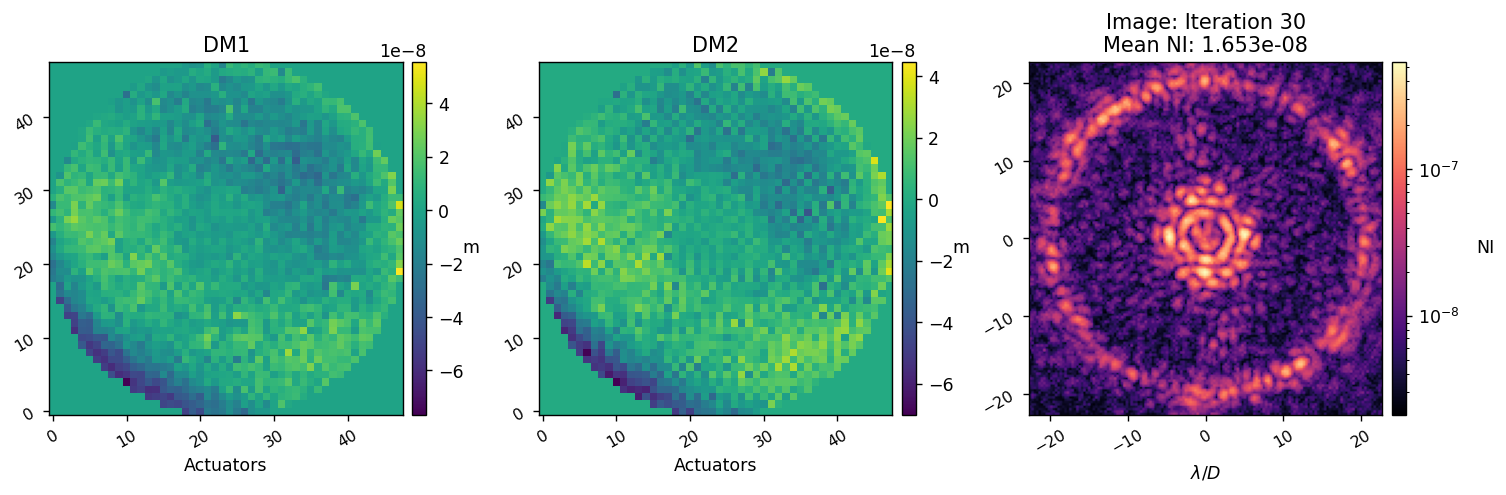

Closed loop for given control matrix completed in 23.143s.


In [86]:
reload(iefc_2dm)
reload(utils)

mode.normalize = True

images, dm1_commands, dm2_commands, regs = iefc_2dm.run(mode, 
                                                        response_matrix,
                                                        reg_fun, reg_conds, 
                                                        probe_modes, 
                                                        probe_amp, 
                                                        calib_modes,
                                                        control_mask, 
                                                        num_iterations=3, 
                                                        loop_gain=0.5, 
                                                        leakage=0,
                                                        probe_exp_time=probe_exp_times,
                                                        probe_nframes=probe_Nframes,
                                                        probe_em_gain=probe_em_gain,
                                                        metric_exp_time=metric_exp_times,
                                                        metric_nframes=metric_Nframes,
                                                        metric_em_gain=metric_em_gain,
                                                        plot_all=True,
                                                        plot_radial_contrast=False,
                                                        old_images=images,
                                                        old_dm1_commands=dm1_commands,
                                                        old_dm2_commands=dm2_commands,
                                                        old_regs=regs,
                                              )

Running iEFC...
	Closed-loop iteration 19 / 21


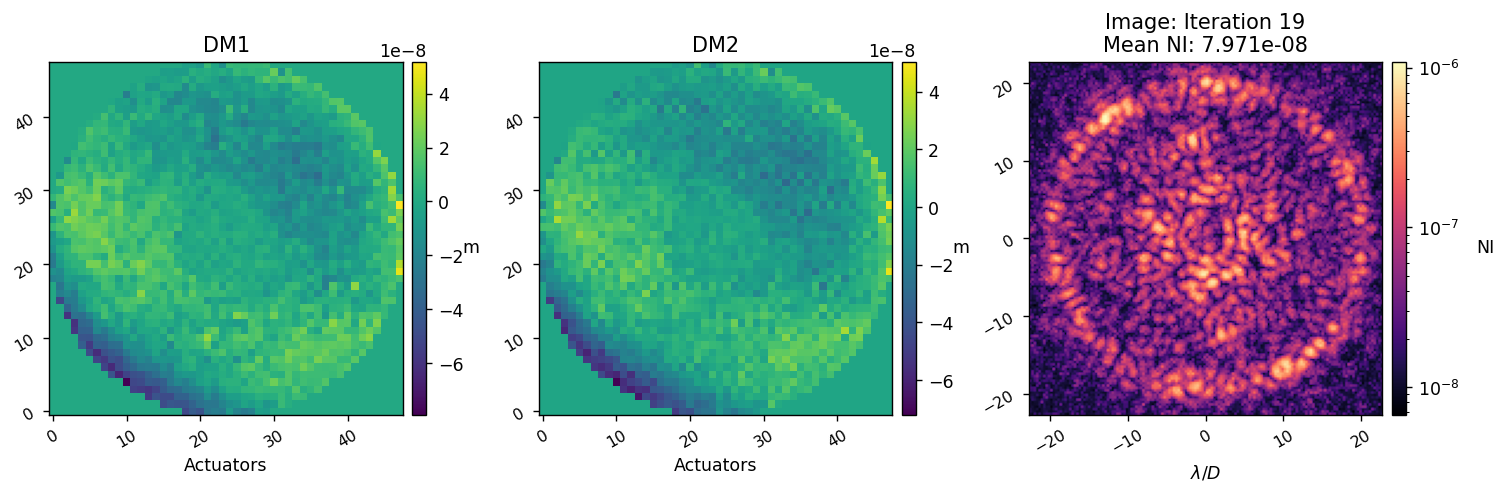

	Closed-loop iteration 20 / 21


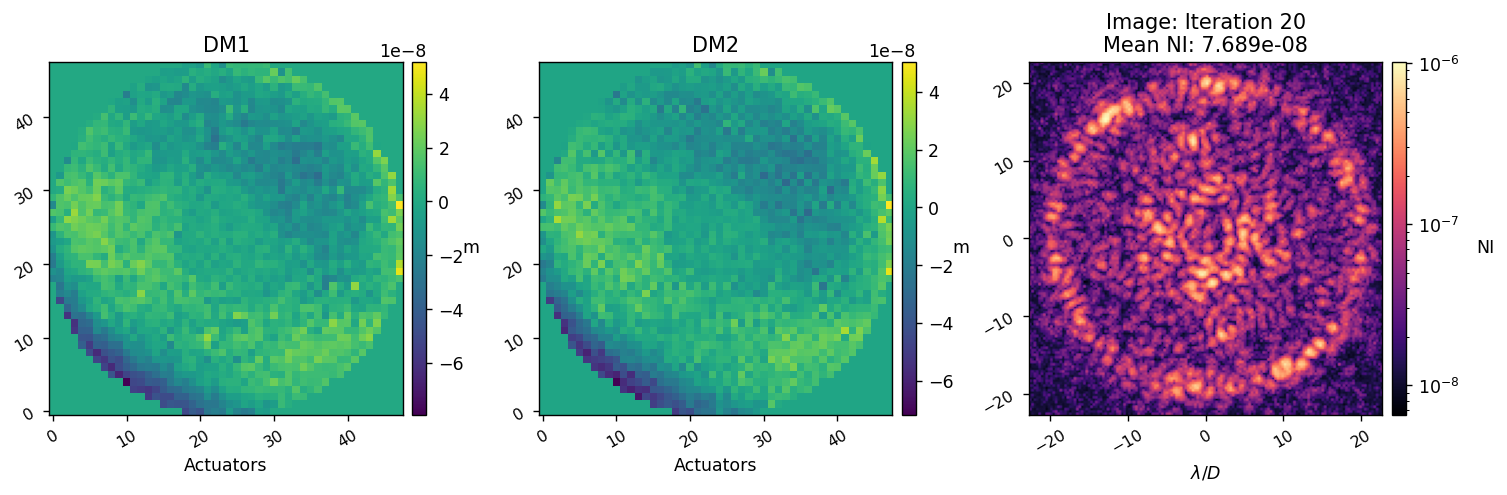

	Closed-loop iteration 21 / 21


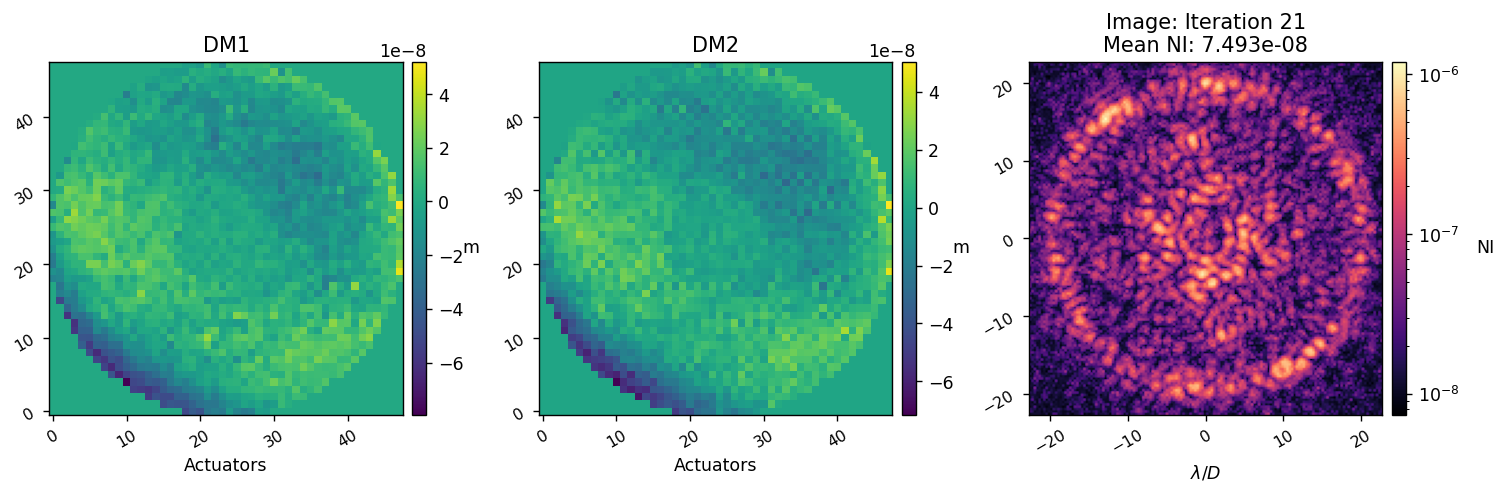

Closed loop for given control matrix completed in 23.273s.


In [145]:
reload(iefc_2dm)
reload(utils)

mode.normalize = True

images, dm1_commands, dm2_commands, regs = iefc_2dm.run(mode, 
                                                        response_matrix,
                                                        reg_fun, reg_conds, 
                                                        probe_modes, 
                                                        probe_amp, 
                                                        calib_modes,
                                                        control_mask, 
                                                        num_iterations=3, 
                                                        loop_gain=0.5, 
                                                        leakage=0,
                                                        probe_exp_time=probe_exp_times,
                                                        probe_nframes=probe_Nframes,
                                                        probe_em_gain=250,
                                                        metric_exp_time=metric_exp_times,
                                                        metric_nframes=5,
                                                        metric_em_gain=250,
                                                        plot_all=True,
                                                        plot_radial_contrast=False,
                                                        old_images=images,
                                                        old_dm1_commands=dm1_commands,
                                                        old_dm2_commands=dm2_commands,
                                                        old_regs=regs,
                                              )

In [97]:
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_dm1_commands_{today}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_dm2_commands_{today}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_images_{today}.fits', images)
utils.save_fits(response_dir/f'spc_wfov_band4b_emccd_regs_{today}.fits', regs)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_dm1_commands_20240104.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_dm2_commands_20240104.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_images_20240104.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4b_emccd_regs_20240104.fits
